<a href="https://colab.research.google.com/github/aury1698/Alzheimer_Prediction_CNN/blob/main/Alzheimer_Prediction_DataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer Prediction with Custom CNN (with Data Augmentation)

### Importing Necessary Libraries 📚

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
 #%run '/content/drive/MyDrive/Colab Notebooks/setup.ipynb'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler


plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams['figure.dpi'] = 300
colors = ["#06d6a0", "#EF476F", "#ffd166", "#118ab2"]

In [4]:
try:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('GPU active! -', torch.cuda.get_device_name(0))
    else:
        device = torch.device('cpu')
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU not active!


In [5]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [6]:
# from google.colab import files
# # Carica il file JSON delle credenziali
# uploaded = files.upload()

# # Sposta il file nel percorso corretto
# !mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [7]:
#!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset -p '/content/drive/MyDrive/DEEP LEARNING/'


In [8]:
#!unzip -q '/content/drive/MyDrive/DEEP LEARNING/alzheimer-mri-dataset.zip' -d '/content/drive/MyDrive/DEEP LEARNING/'

### Target Value Distribution 🎯

There are degrees of severity in Alzheimer.


1.  **Very mildly demented** (2240 images): This is the stage where patient starts to forget where they put their stuff, other people's names recently, etc. It is hard to detect through cognitive ability test.
2.  **Mildly demented**  (896 images): This is the stage where patients don't remember the words, can't find their way to the destination, loss of focus and work-abilities. This is also the stage where patients even forget that they are losing memory. From this stage, with cognitive testing, it can be found
3. **Moderately demented** (64 images): Starts to forget the recent activities, important old histories, have hard time calculating the budget, hard to go outside alone, and loss of empathy.
4. **Non Demented** (3200 images).

Seeing the distribution of the target values is of critical importance in determining the methods to be applied in the subsequent steps. Therefore, let's first navigate to the data folder path and check the number of images in each class folder.

In [9]:
# %run -i '/content/drive/MyDrive/Colab Notebooks/utils.ipynb'

A search has been initiated within the folder named 'Dataset'.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


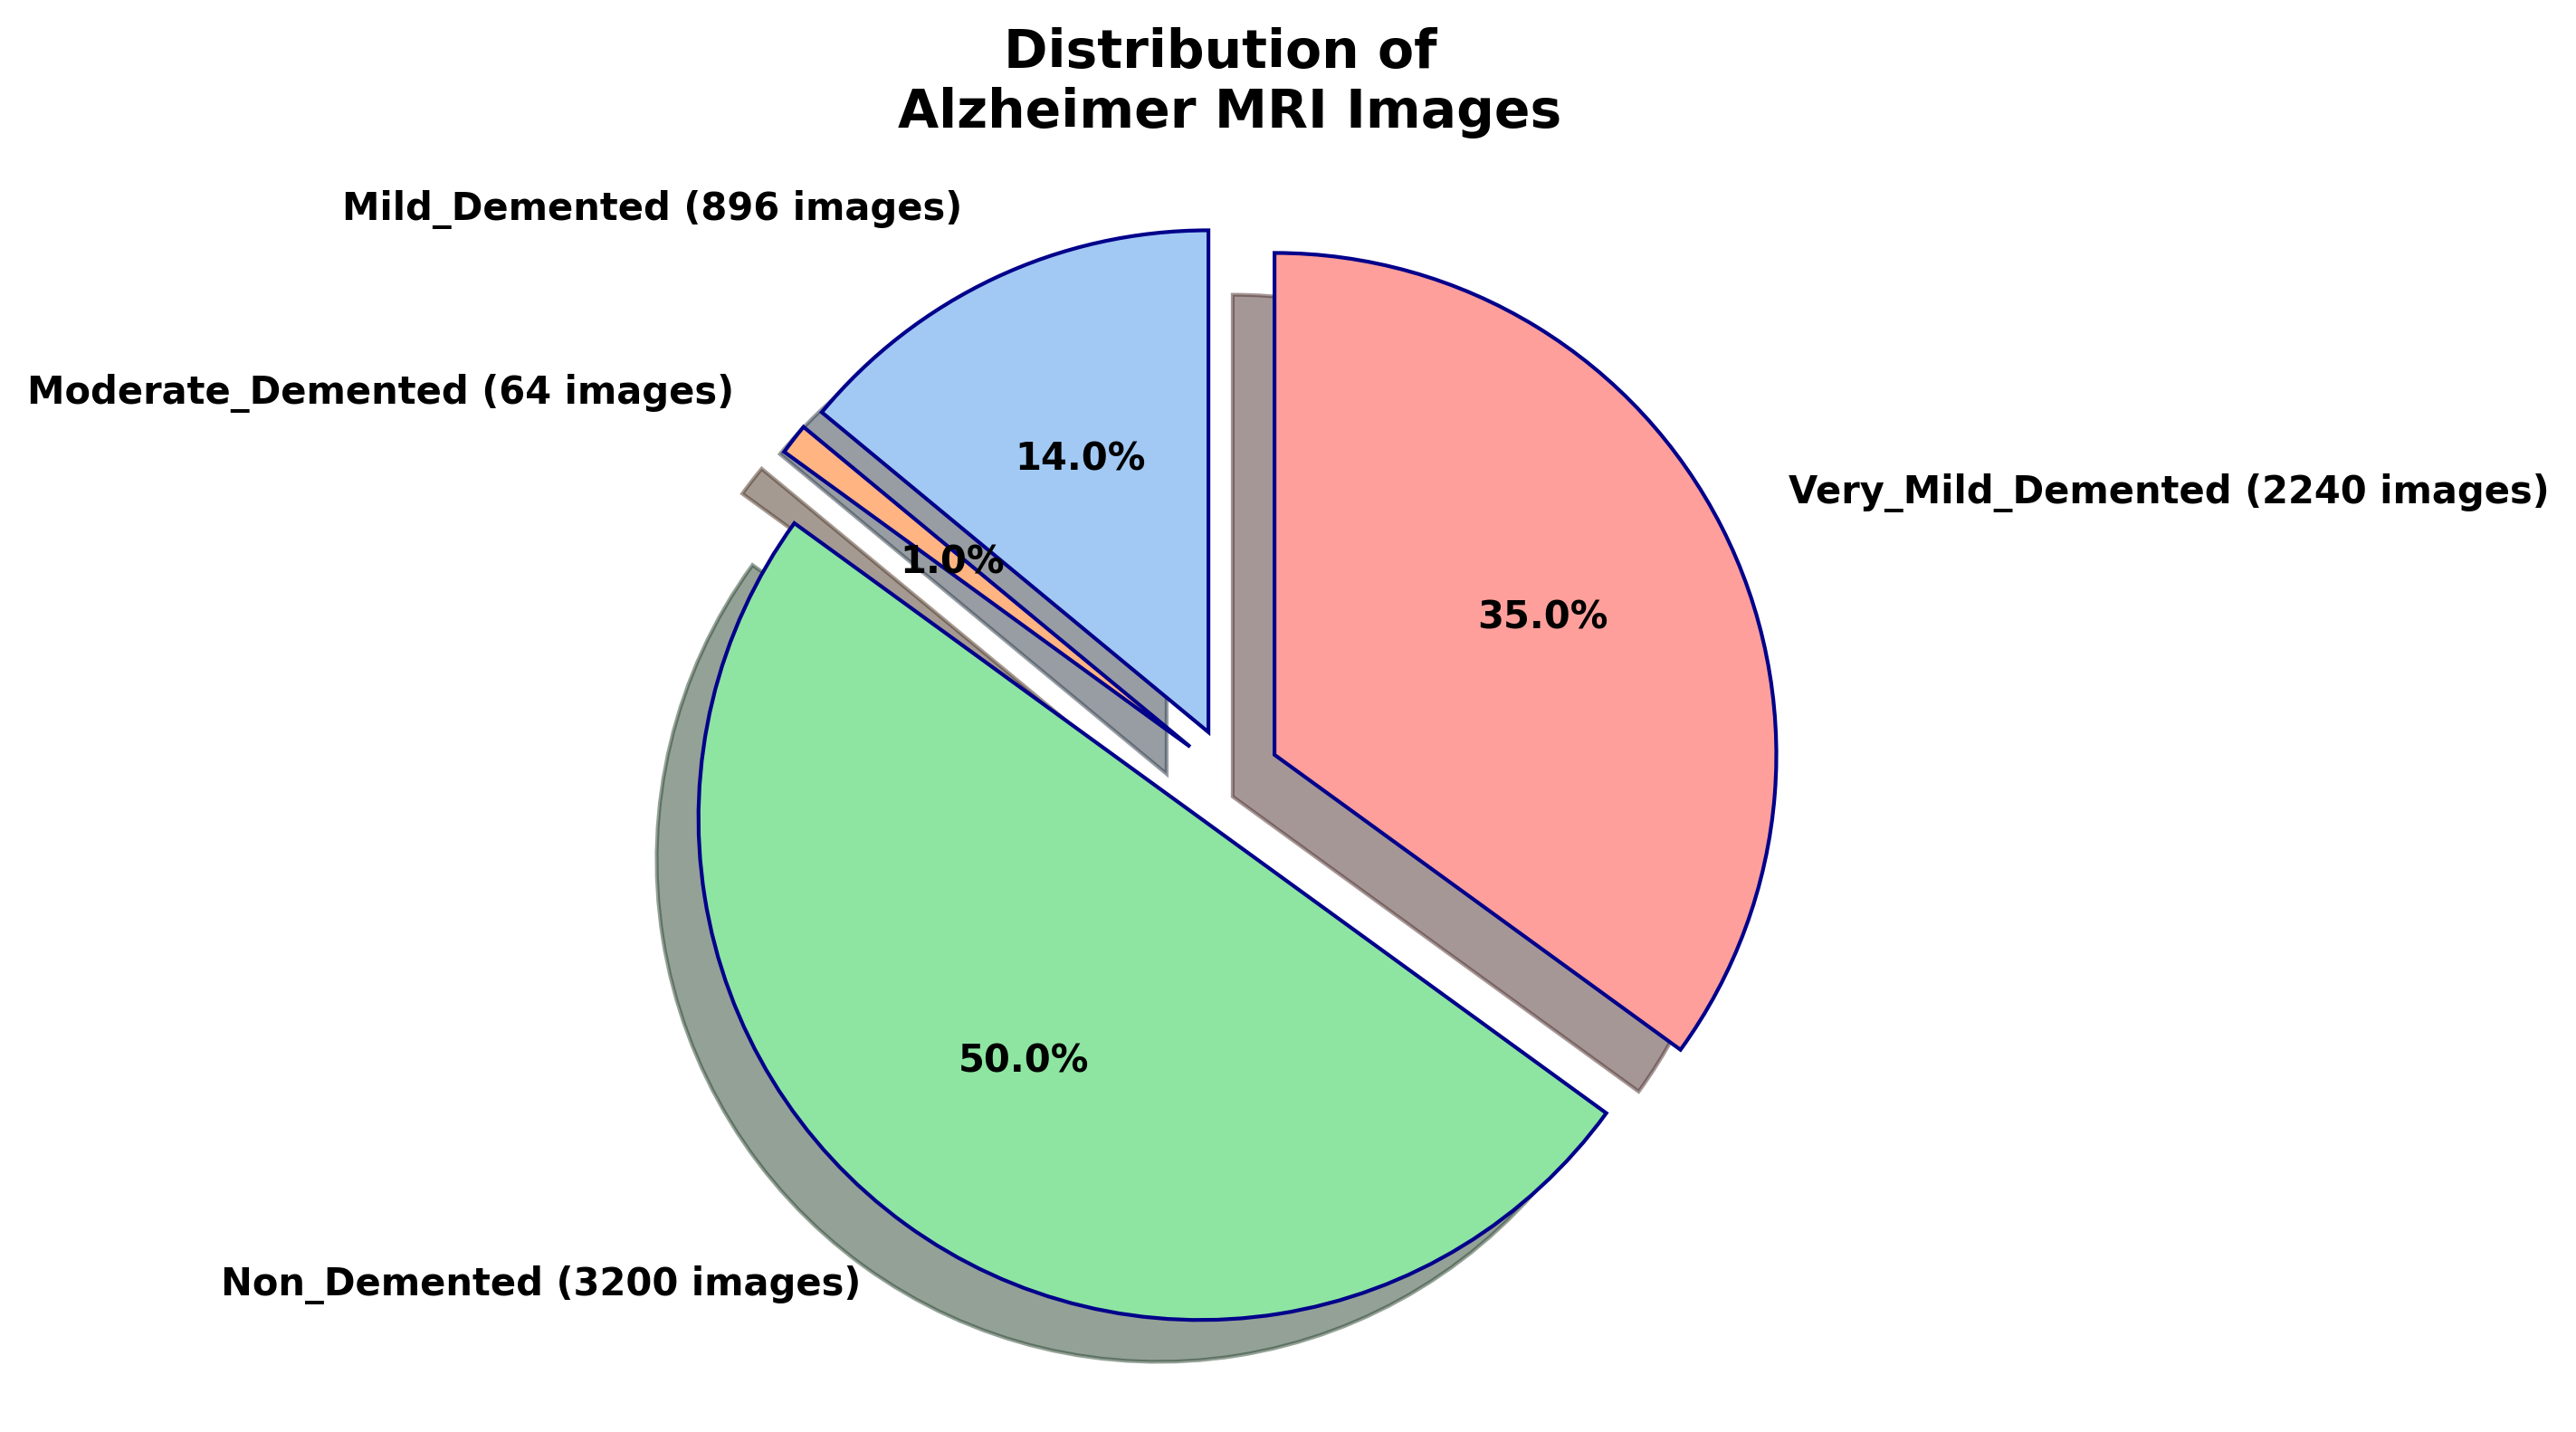

In [10]:
import os

# Dizionario per la distribuzione delle classi
class_distribution = {}

def count_images_in_folder(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m' + f"A search has been initiated within the folder named '{basename}'." + '\033[0m')
    img_ext = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in img_ext:
                    count += 1

            class_distribution[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")

    print('\033[92m' + "The search has been completed." + '\033[0m')

    # Preparazione dati per il grafico a torta
    keys = list(class_distribution.keys())
    values = list(class_distribution.values())
    explode = (0.1,) * len(keys)  # Evidenzia ogni fetta

    # Creazione delle etichette per le fette
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    # Colori pastello per il grafico a torta
    pie_colors = sns.color_palette("pastel", len(keys))

    # Creazione del grafico a torta
    plt.figure(figsize=(6, 6))
    plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=pie_colors,
            textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'black', 'family': 'sans-serif'},
            wedgeprops={'edgecolor':'darkblue'}, labeldistance=1.15)

    # Imposta il titolo del grafico
    plt.title("Distribution of \nAlzheimer MRI Images", size=14, fontweight="bold")

    # Mostra il grafico
    plt.show()

# Percorso del dataset
PATH = '/content/drive/MyDrive/DEEP LEARNING/Dataset'
#Visual Studio: PATH = './archive/Dataset'

# Chiamata alla funzione
count_images_in_folder(PATH)


As observed in the class distribution, we have an imbalanced dataset. **Non Demented** MRI class constitutes **50%** of the total data with 3200 images, while **Moderate Demented** MRI class **only** makes up **1%** of the dataset with 64 images.

### Generate Dataset 🧬

When examining the data directory structure, it becomes apparent that there is a main folder named "Dataset." Inside this folder, there are individual folders for each class, each containing their respective images. For example:

Dataset/
...Mild_Demented/
......mild_1.jpg
......mild_2.jpg
...Moderate_Demented/
......moderate_1.jpg
......moderate_2.jpg

In such a scenario, PyTorch offers a powerful function, torchvision.datasets.ImageFolder, for data reading.

In [11]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(root=PATH, transform=data_transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True, num_workers=4)

class_names = data.classes

Let's see some samples for each class!

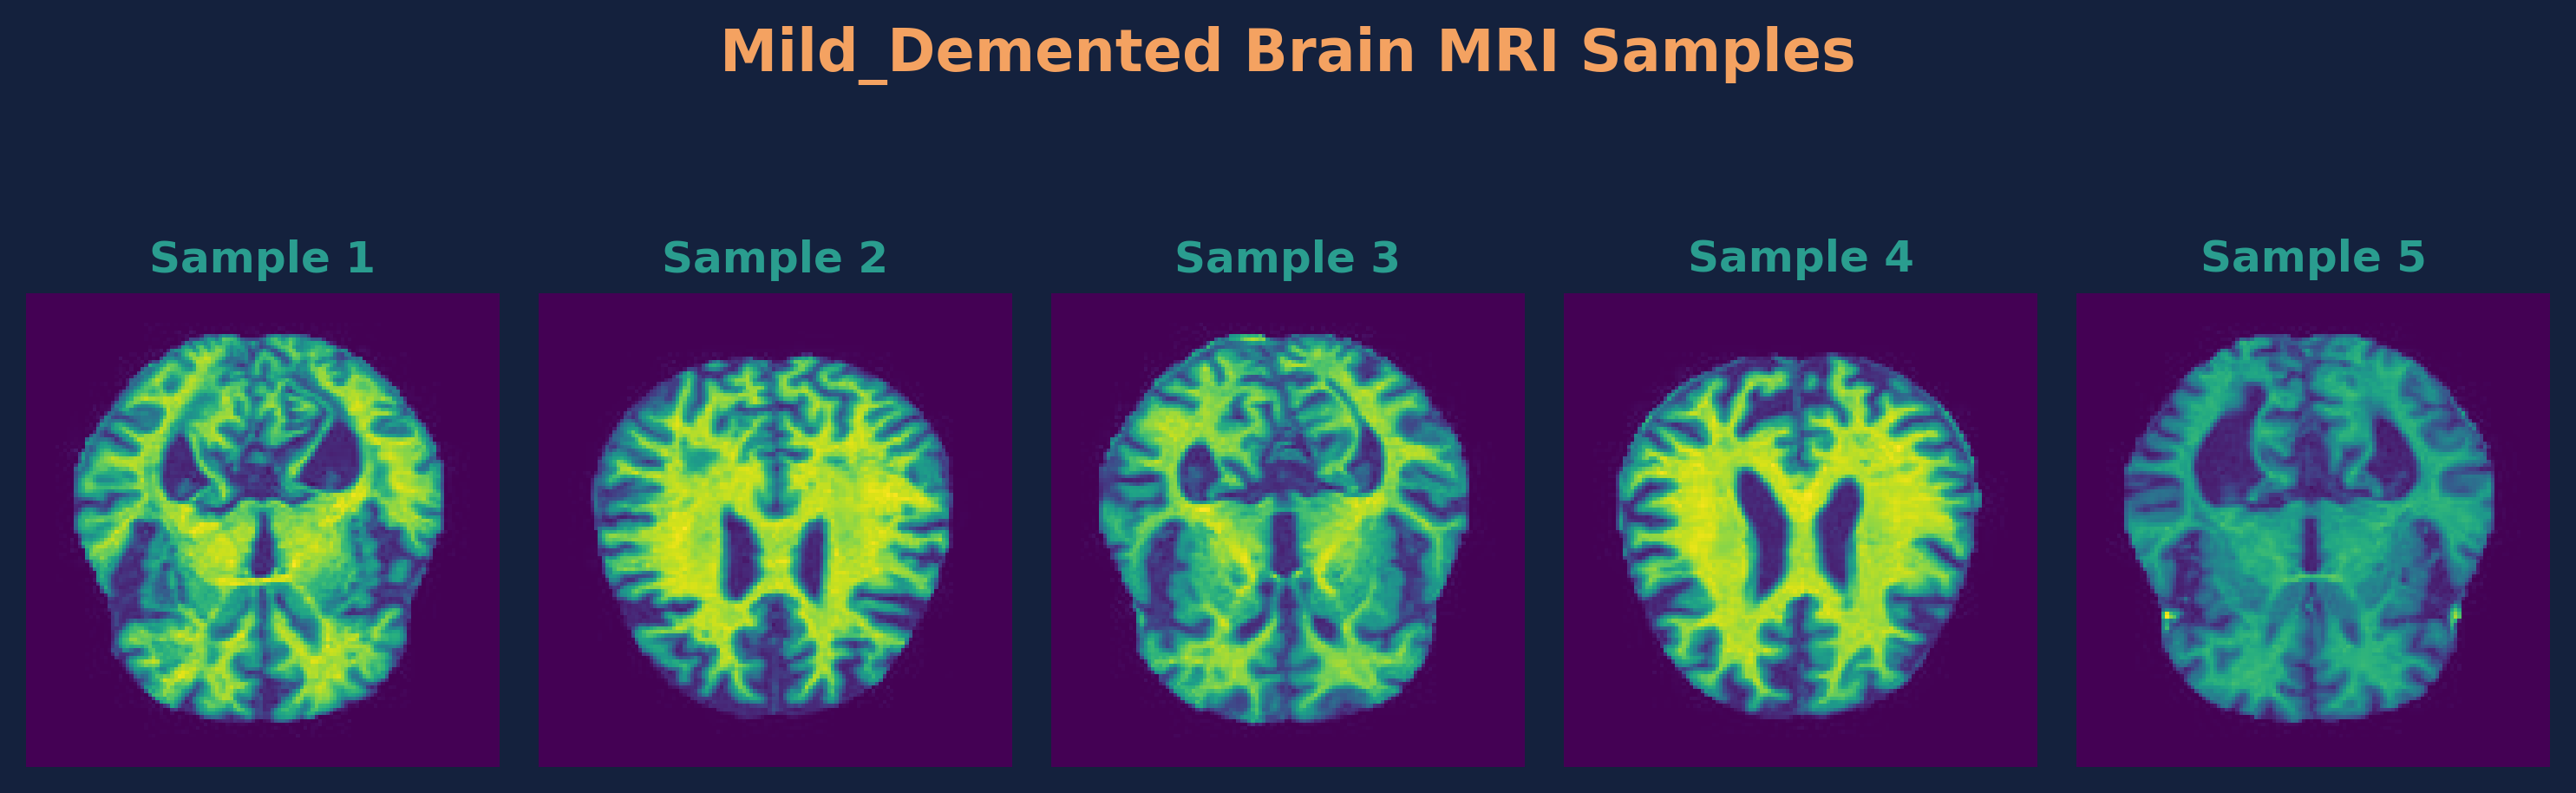

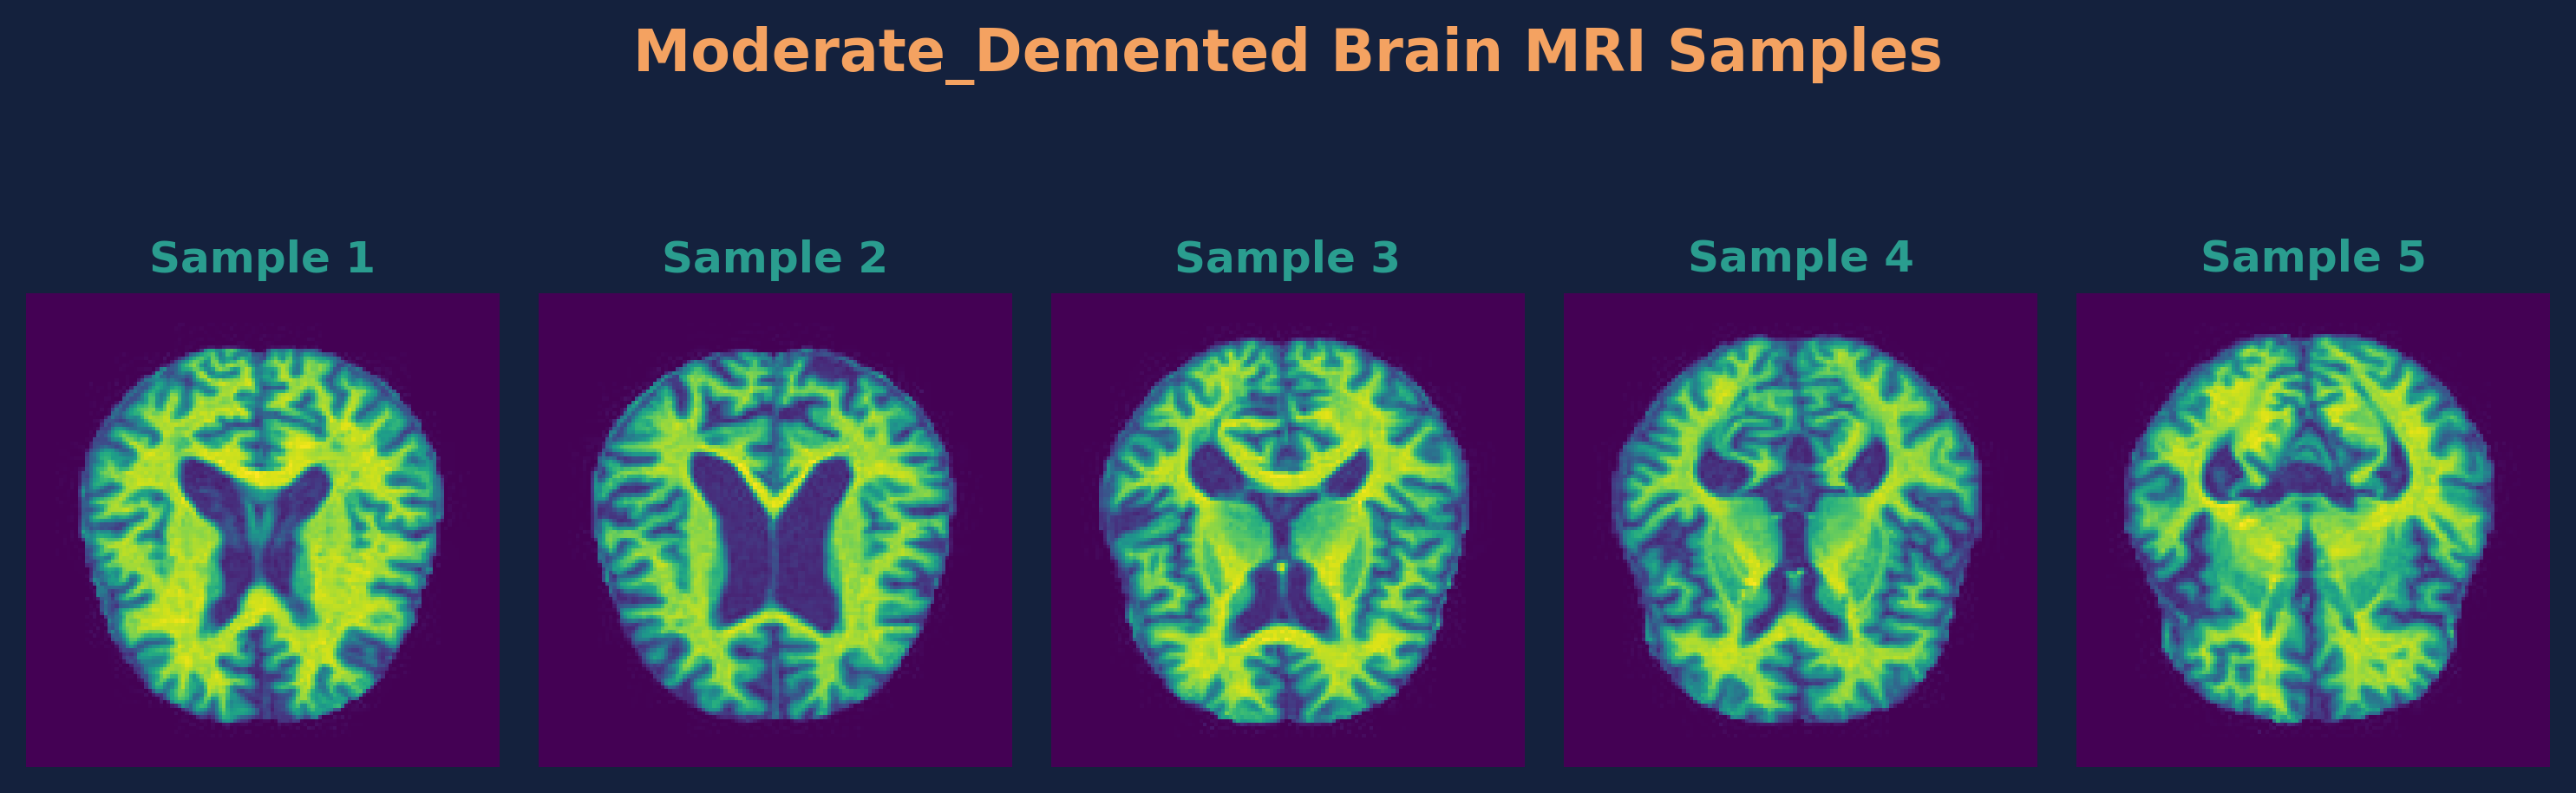

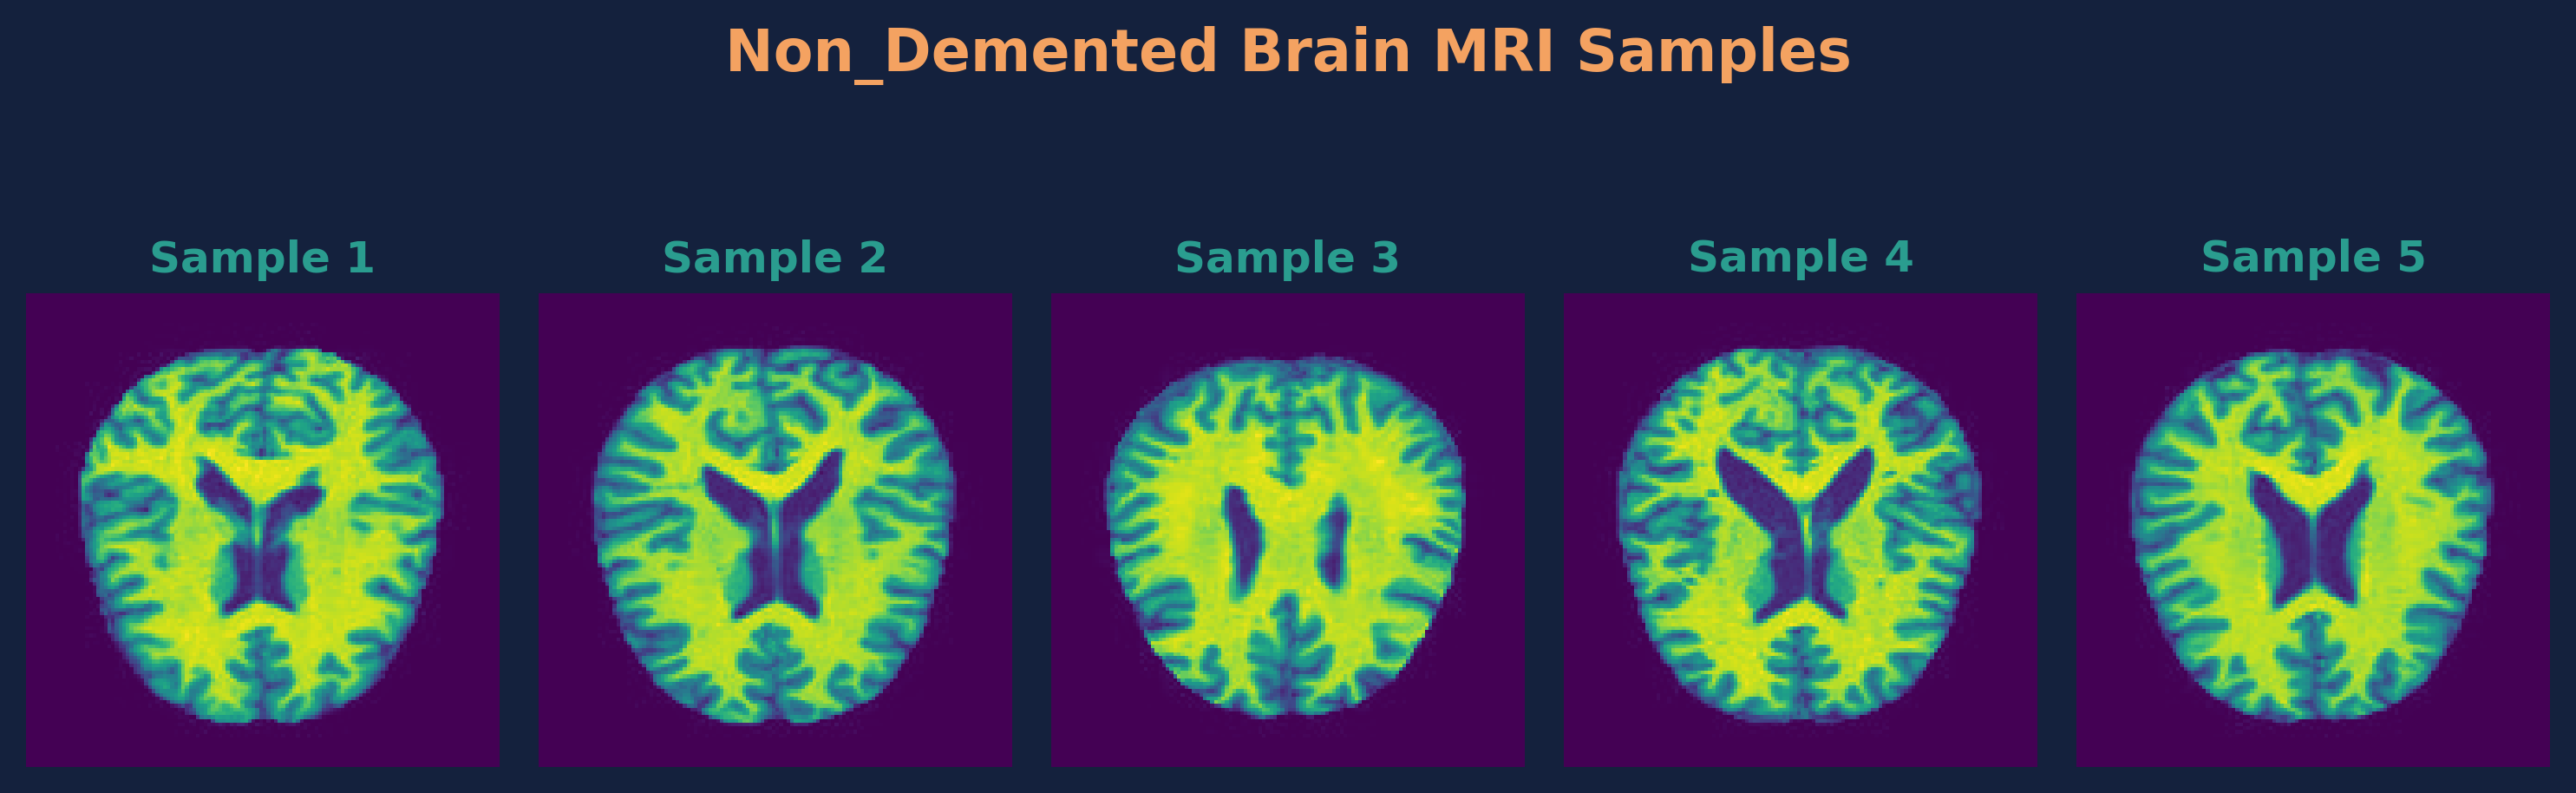

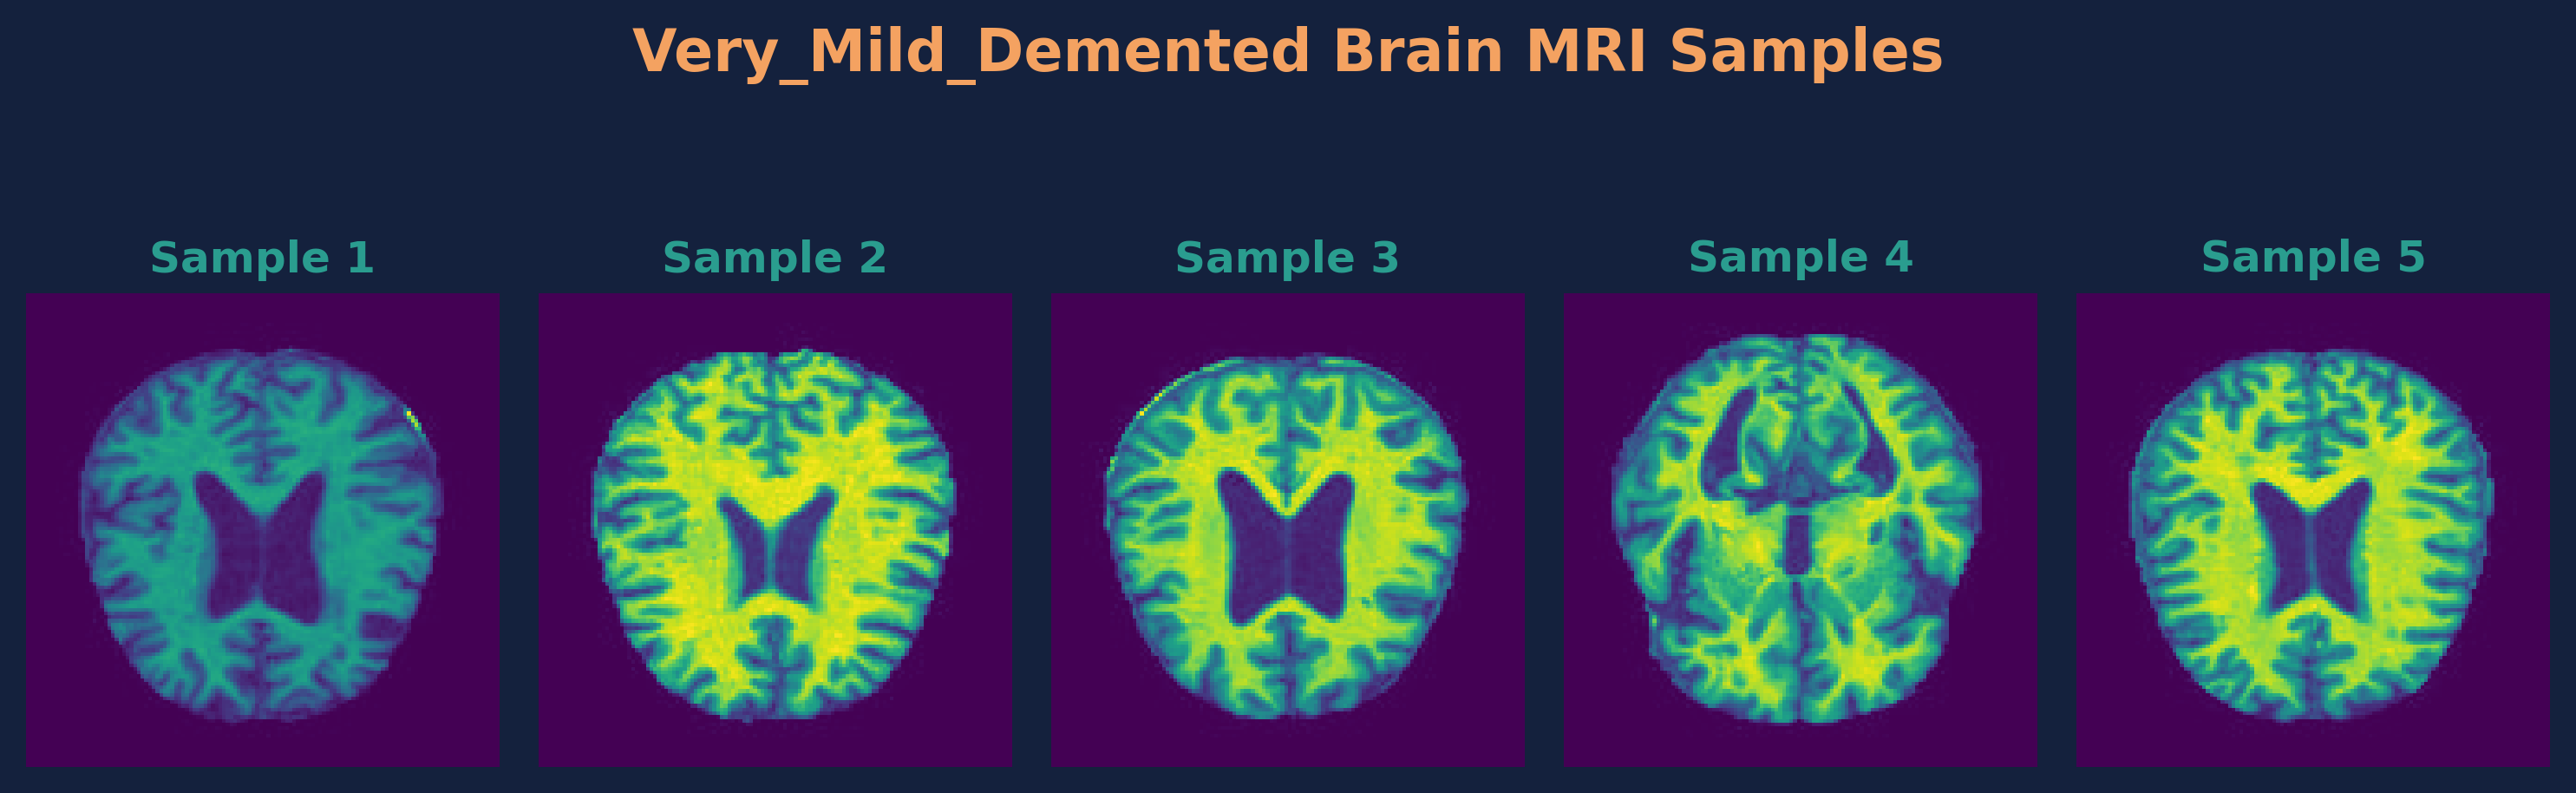

In [24]:
#Define colors for all plots from now on:
background_color = "#14213d"
label_color ="#2a9d8f"
title_color = "#f4a261"

def display_sample_images(path, target, num_samples=5):
    class_path = os.path.join(path, target)
    img_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, subplot_axes = plt.subplots(1, num_samples, facecolor=background_color)
    fig.suptitle(f'{target} Brain MRI Samples', color=title_color, fontsize=16, fontweight='bold', y=0.75)

    for i in range(num_samples):
        image_path = os.path.join(class_path, img_files[i])
        img = mpimg.imread(image_path)

        subplot_axes[i].imshow(img)
        subplot_axes[i].axis('off')
        subplot_axes[i].set_title(f'Sample {i+1}', color=label_color, fontweight='bold')

    plt.tight_layout()

for target in class_names:
    display_sample_images(PATH, target=target)


Pixel **normalization** improves the performance of a neural network. Therefore, we will go with pixel values from **0 to 1**, rather than values in the range 0 to 255.

In [13]:
alzheimer_dict = {index: img for index, img in enumerate(data.classes)}

class DataProcessor:
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def generate_new_batch(self):
        self.batch = next(iter(self.data_loader))
        text = "The minimum and maximum pixel values in the batch are -->"
        print(text, self.batch[0].min().item(), "&", self.batch[0].max().item())

    def visualize_batch_images(self, number_of_images=5):
        fig, subplot_axes = plt.subplots(ncols=number_of_images, figsize=(20, 20), facecolor=background_color)
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color=title_color, fontsize=18, fontweight='bold', y=0.6)

        for idx, img in enumerate(self.batch[0][:number_of_images]):
            img = img.permute(1, 2, 0).numpy()  # Change dimension order for display
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0-1
            subplot_axes[idx].imshow(img)
            class_no = int(self.batch[1][idx].item())
            subplot_axes[idx].set_title(alzheimer_dict[class_no], color=label_color, fontweight='bold', fontsize=14)
            subplot_axes[idx].set_xticklabels([])
            subplot_axes[idx].set_yticklabels([])

    def split_train_val_test(self, train_size, val_size, test_size):
        train_count = int(len(self.data_loader.dataset) * train_size)
        val_count = int(len(self.data_loader.dataset) * val_size)
        test_count = len(self.data_loader.dataset) - train_count - val_count

        train_data, val_data, test_data = torch.utils.data.random_split(self.data_loader.dataset, [train_count, val_count, test_count])

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

        return train_loader, val_loader, test_loader


The minimum and maximum pixel values in the batch are --> -2.1179039478302 & 2.640000104904175


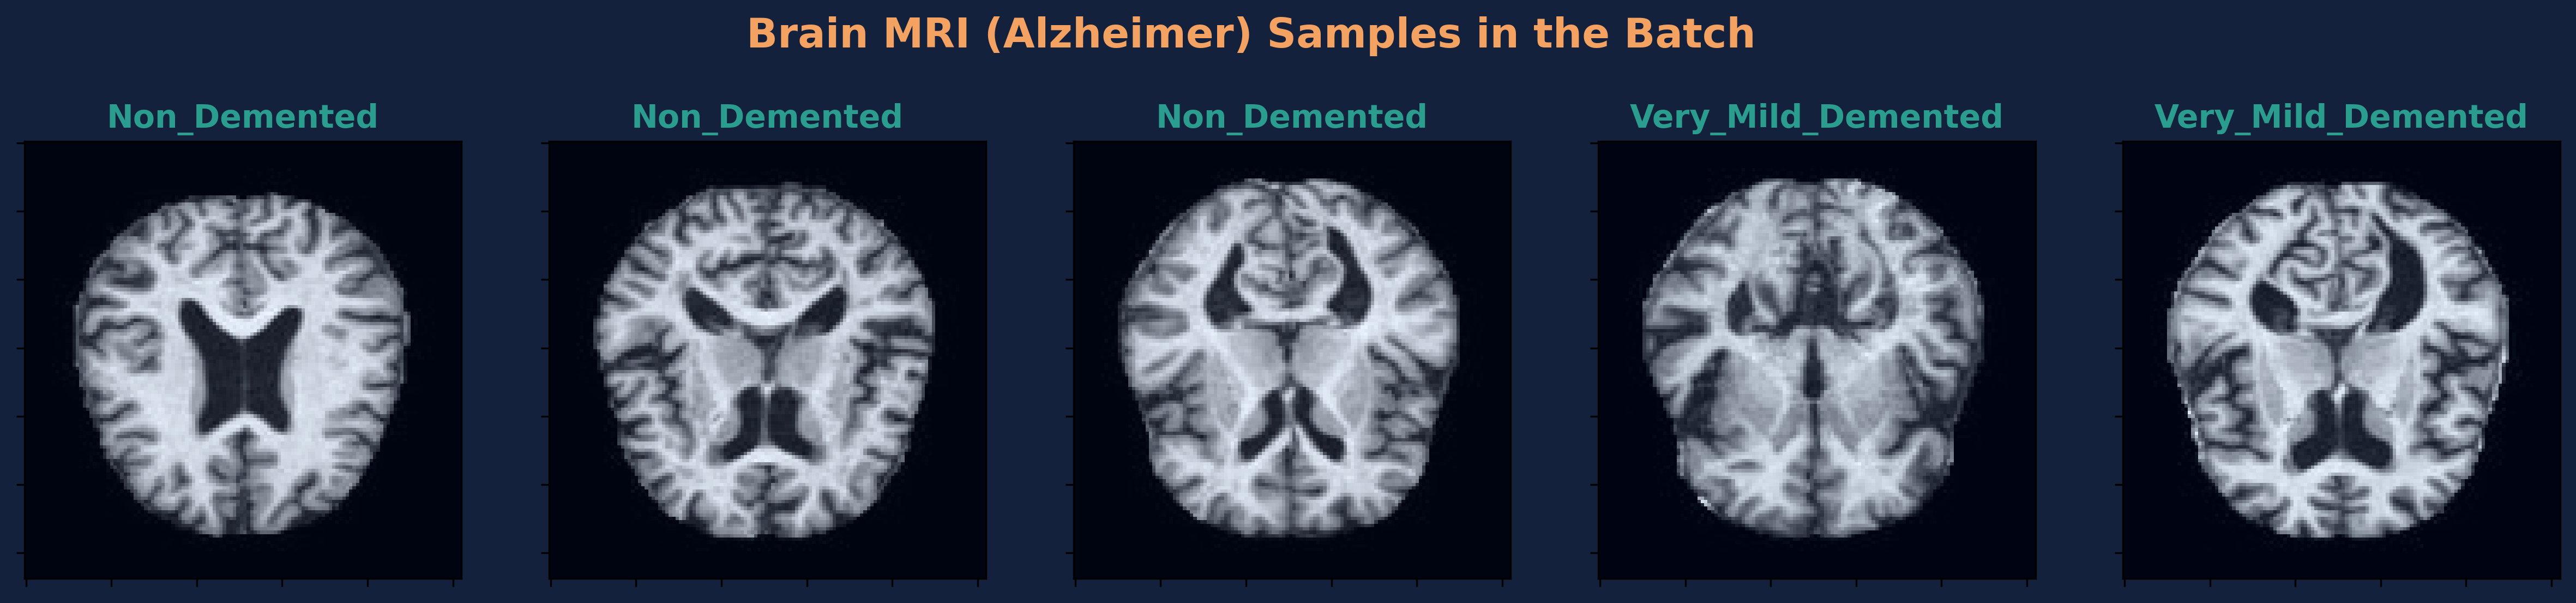

In [14]:
process = DataProcessor(data_loader)
process.generate_new_batch()
process.visualize_batch_images(number_of_images=5)

We will **divide** the dataset into 80% **training** data, 10% **validation** data and 10% **test** data.

In [15]:
train_loader, val_loader, test_loader = process.split_train_val_test(train_size=0.8, val_size=0.1, test_size=0.1)


We have an imbalanced distribution of target class. When dealing with an imbalanced target class distribution, using class weights can help the model perform better and effectively recognize the minority classes. Therefore, let's calculate the weights of the target classes in our training data and provide this information to our model during training.

In [16]:
y_train = []
for _, y in train_loader:
    y_train.append(y)
y_train = torch.cat(y_train, dim=0)

# Calcolo del peso per ogni classe
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Creazione di un dizionario dei pesi delle classi se necessario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Data Augmentation

Now let's try to agumentate our Training data. Let's start by checking our images prior to the transformation.

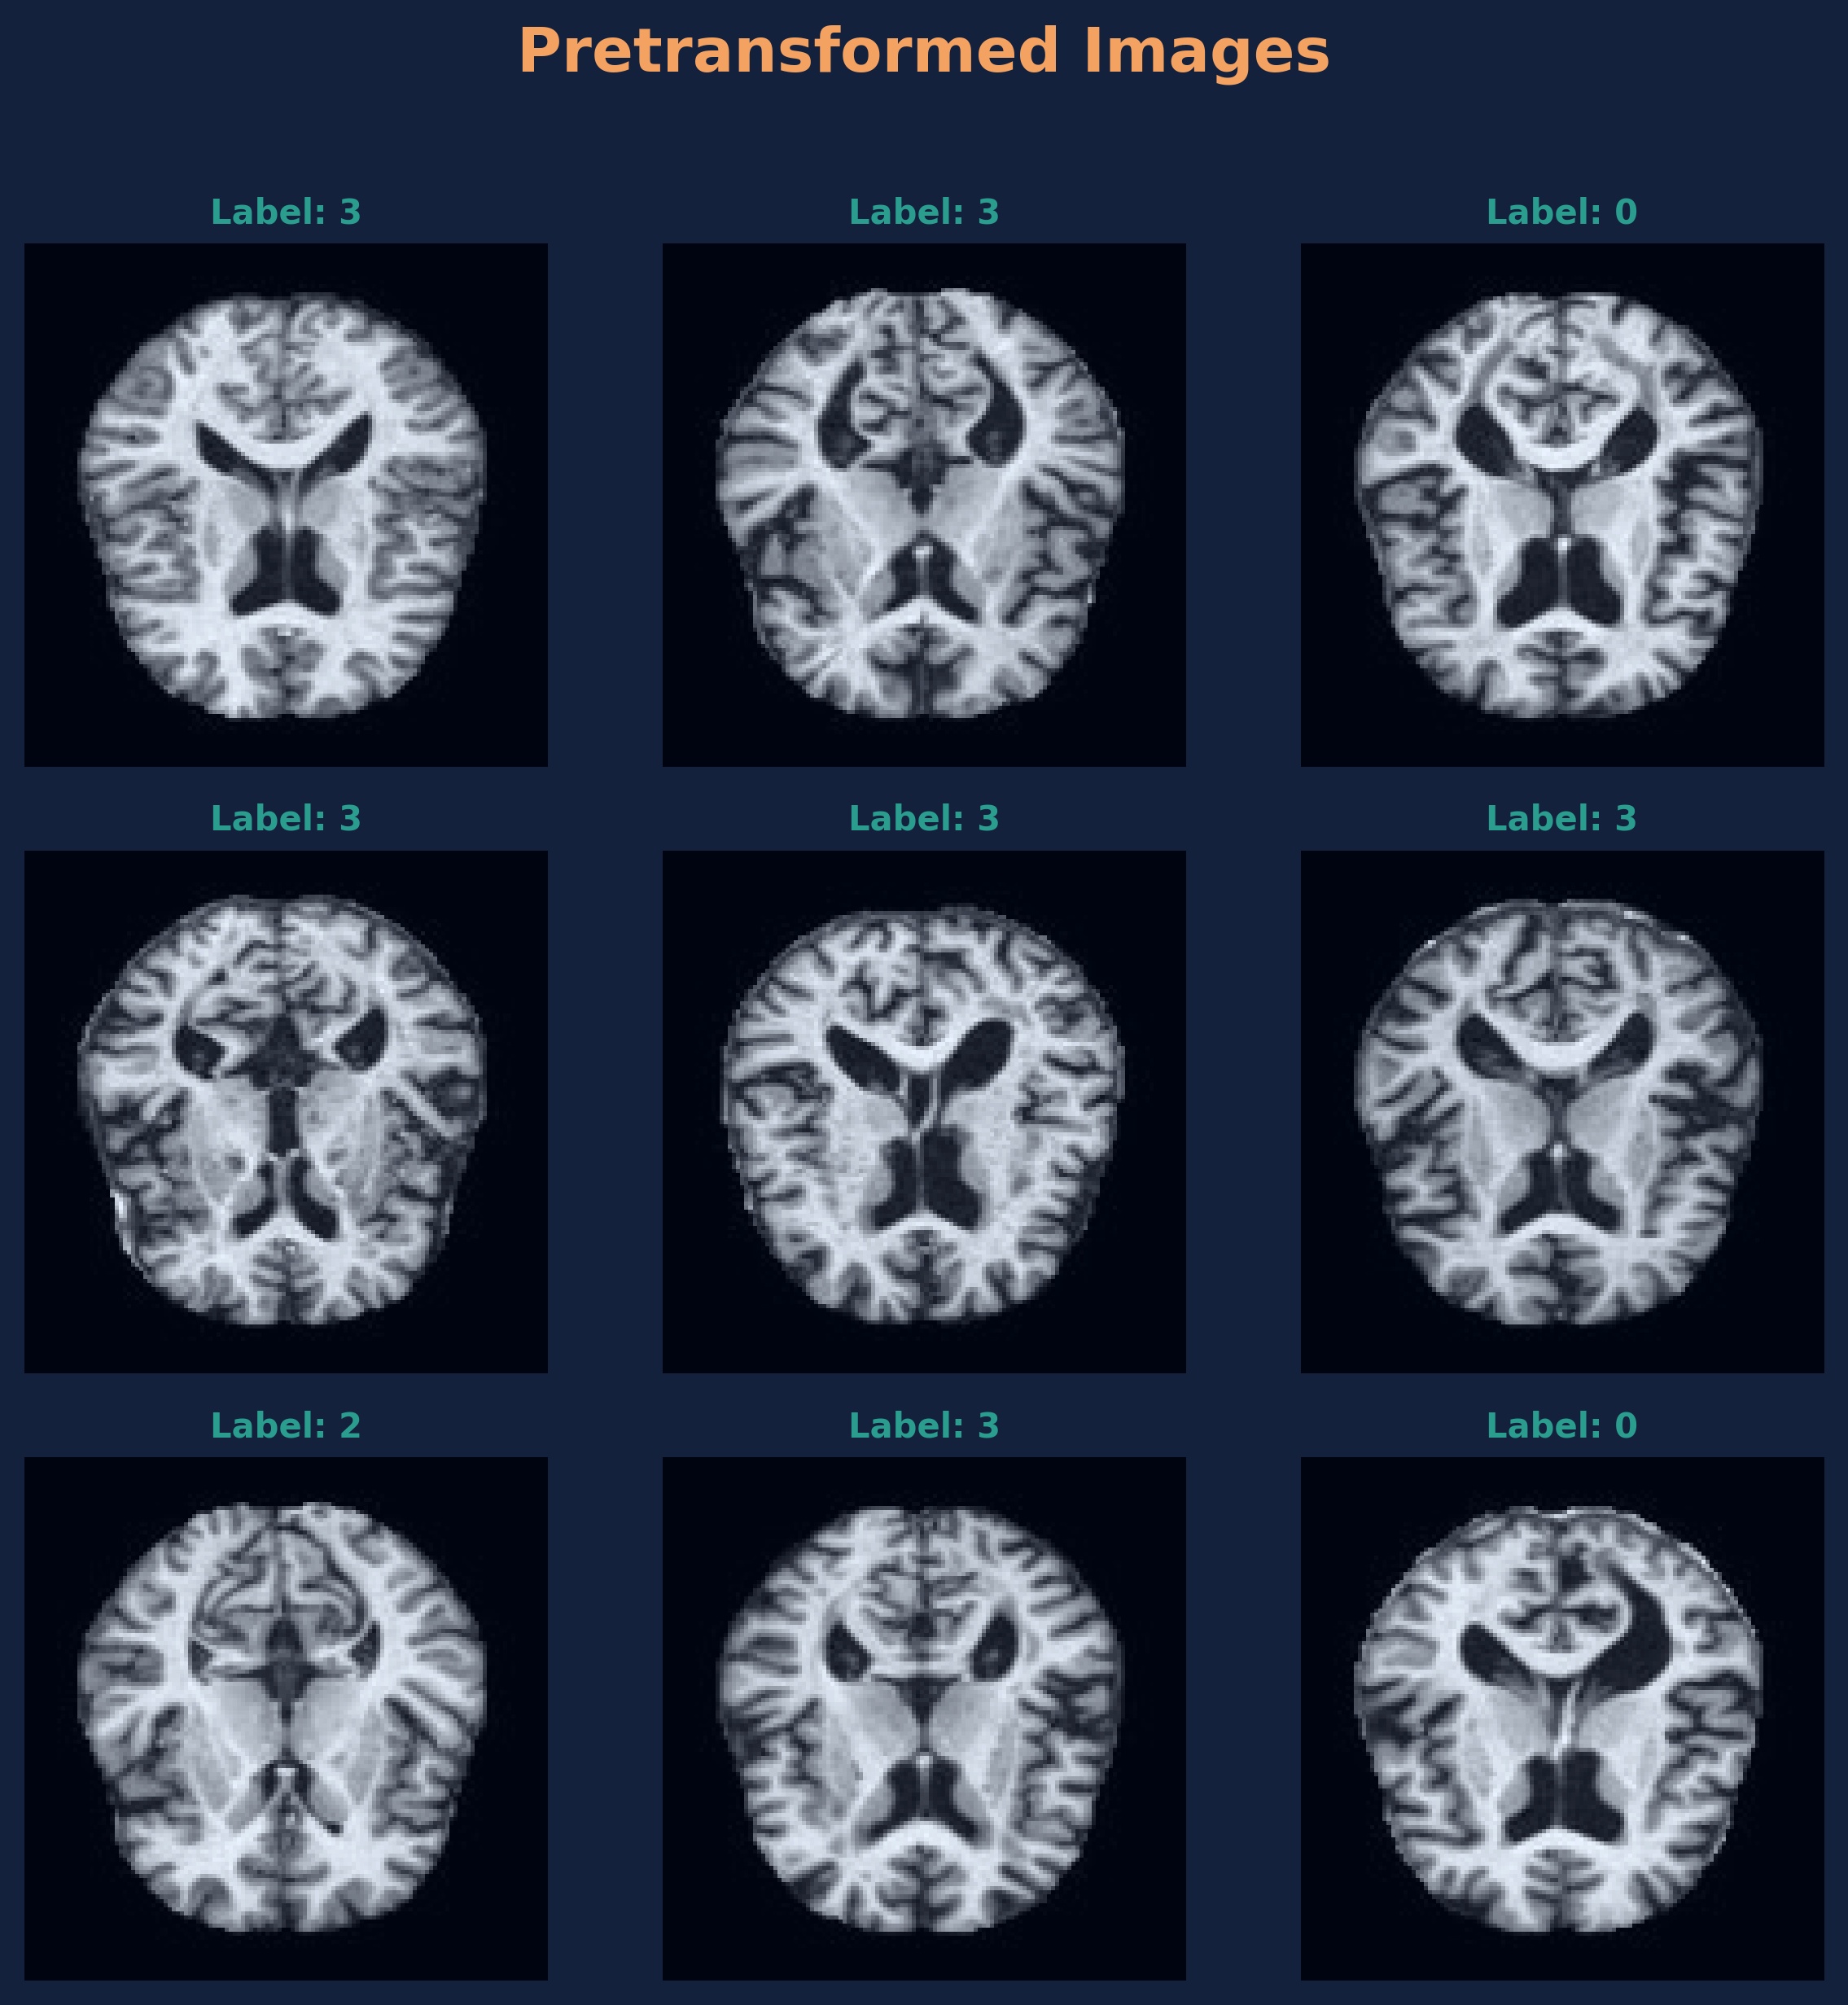

In [17]:
def display_pretransformed_images(dataset, num_images):
    fig, subplot_axes = plt.subplots(3, 3, figsize=(8, 8), facecolor=background_color)
    fig.suptitle("Pretransformed Images", color=title_color, fontsize=18, fontweight='bold', y=1.02)

    data_iter = iter(dataset)
    images, labels = next(data_iter)  # Usa next() con l'iteratore esplicito

    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalizza a 0-1
        ax = subplot_axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}", fontsize=10, color=label_color, fontweight='bold')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualizza le immagini trasformate
display_pretransformed_images(train_loader, 9)

In [18]:
import random
# Imposta il seed per la libreria random di Python
random.seed(42)

# Imposta il seed per PyTorch
torch.manual_seed(42)

# Definizione delle trasformazioni per il training set con data augmentation
data_augmentation = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.01)
    ]),
    transforms.ToTensor()  # Converti in Tensor
])



# Creazione del dataset di training con le trasformazioni augmentate
train_data_with_augmentation = datasets.ImageFolder(root=PATH, transform=data_augmentation)

# Creazione del data loader per il dataset di training con le trasformazioni augmentate
train_loader_with_augmentation = torch.utils.data.DataLoader(train_data_with_augmentation, batch_size=32, shuffle=True, num_workers=4)


In [19]:
def display_transformed_images(dataset, num_images):

    plt.figure(figsize=(8, 8), facecolor=background_color)
    plt.suptitle("Transformed Images", color=title_color, fontsize=18, fontweight='bold', y=0.98)

    data_iter = iter(dataset)
    images, labels = next(data_iter)

    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalizza a 0-1
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}", fontsize=10, color=label_color, fontweight='bold')
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



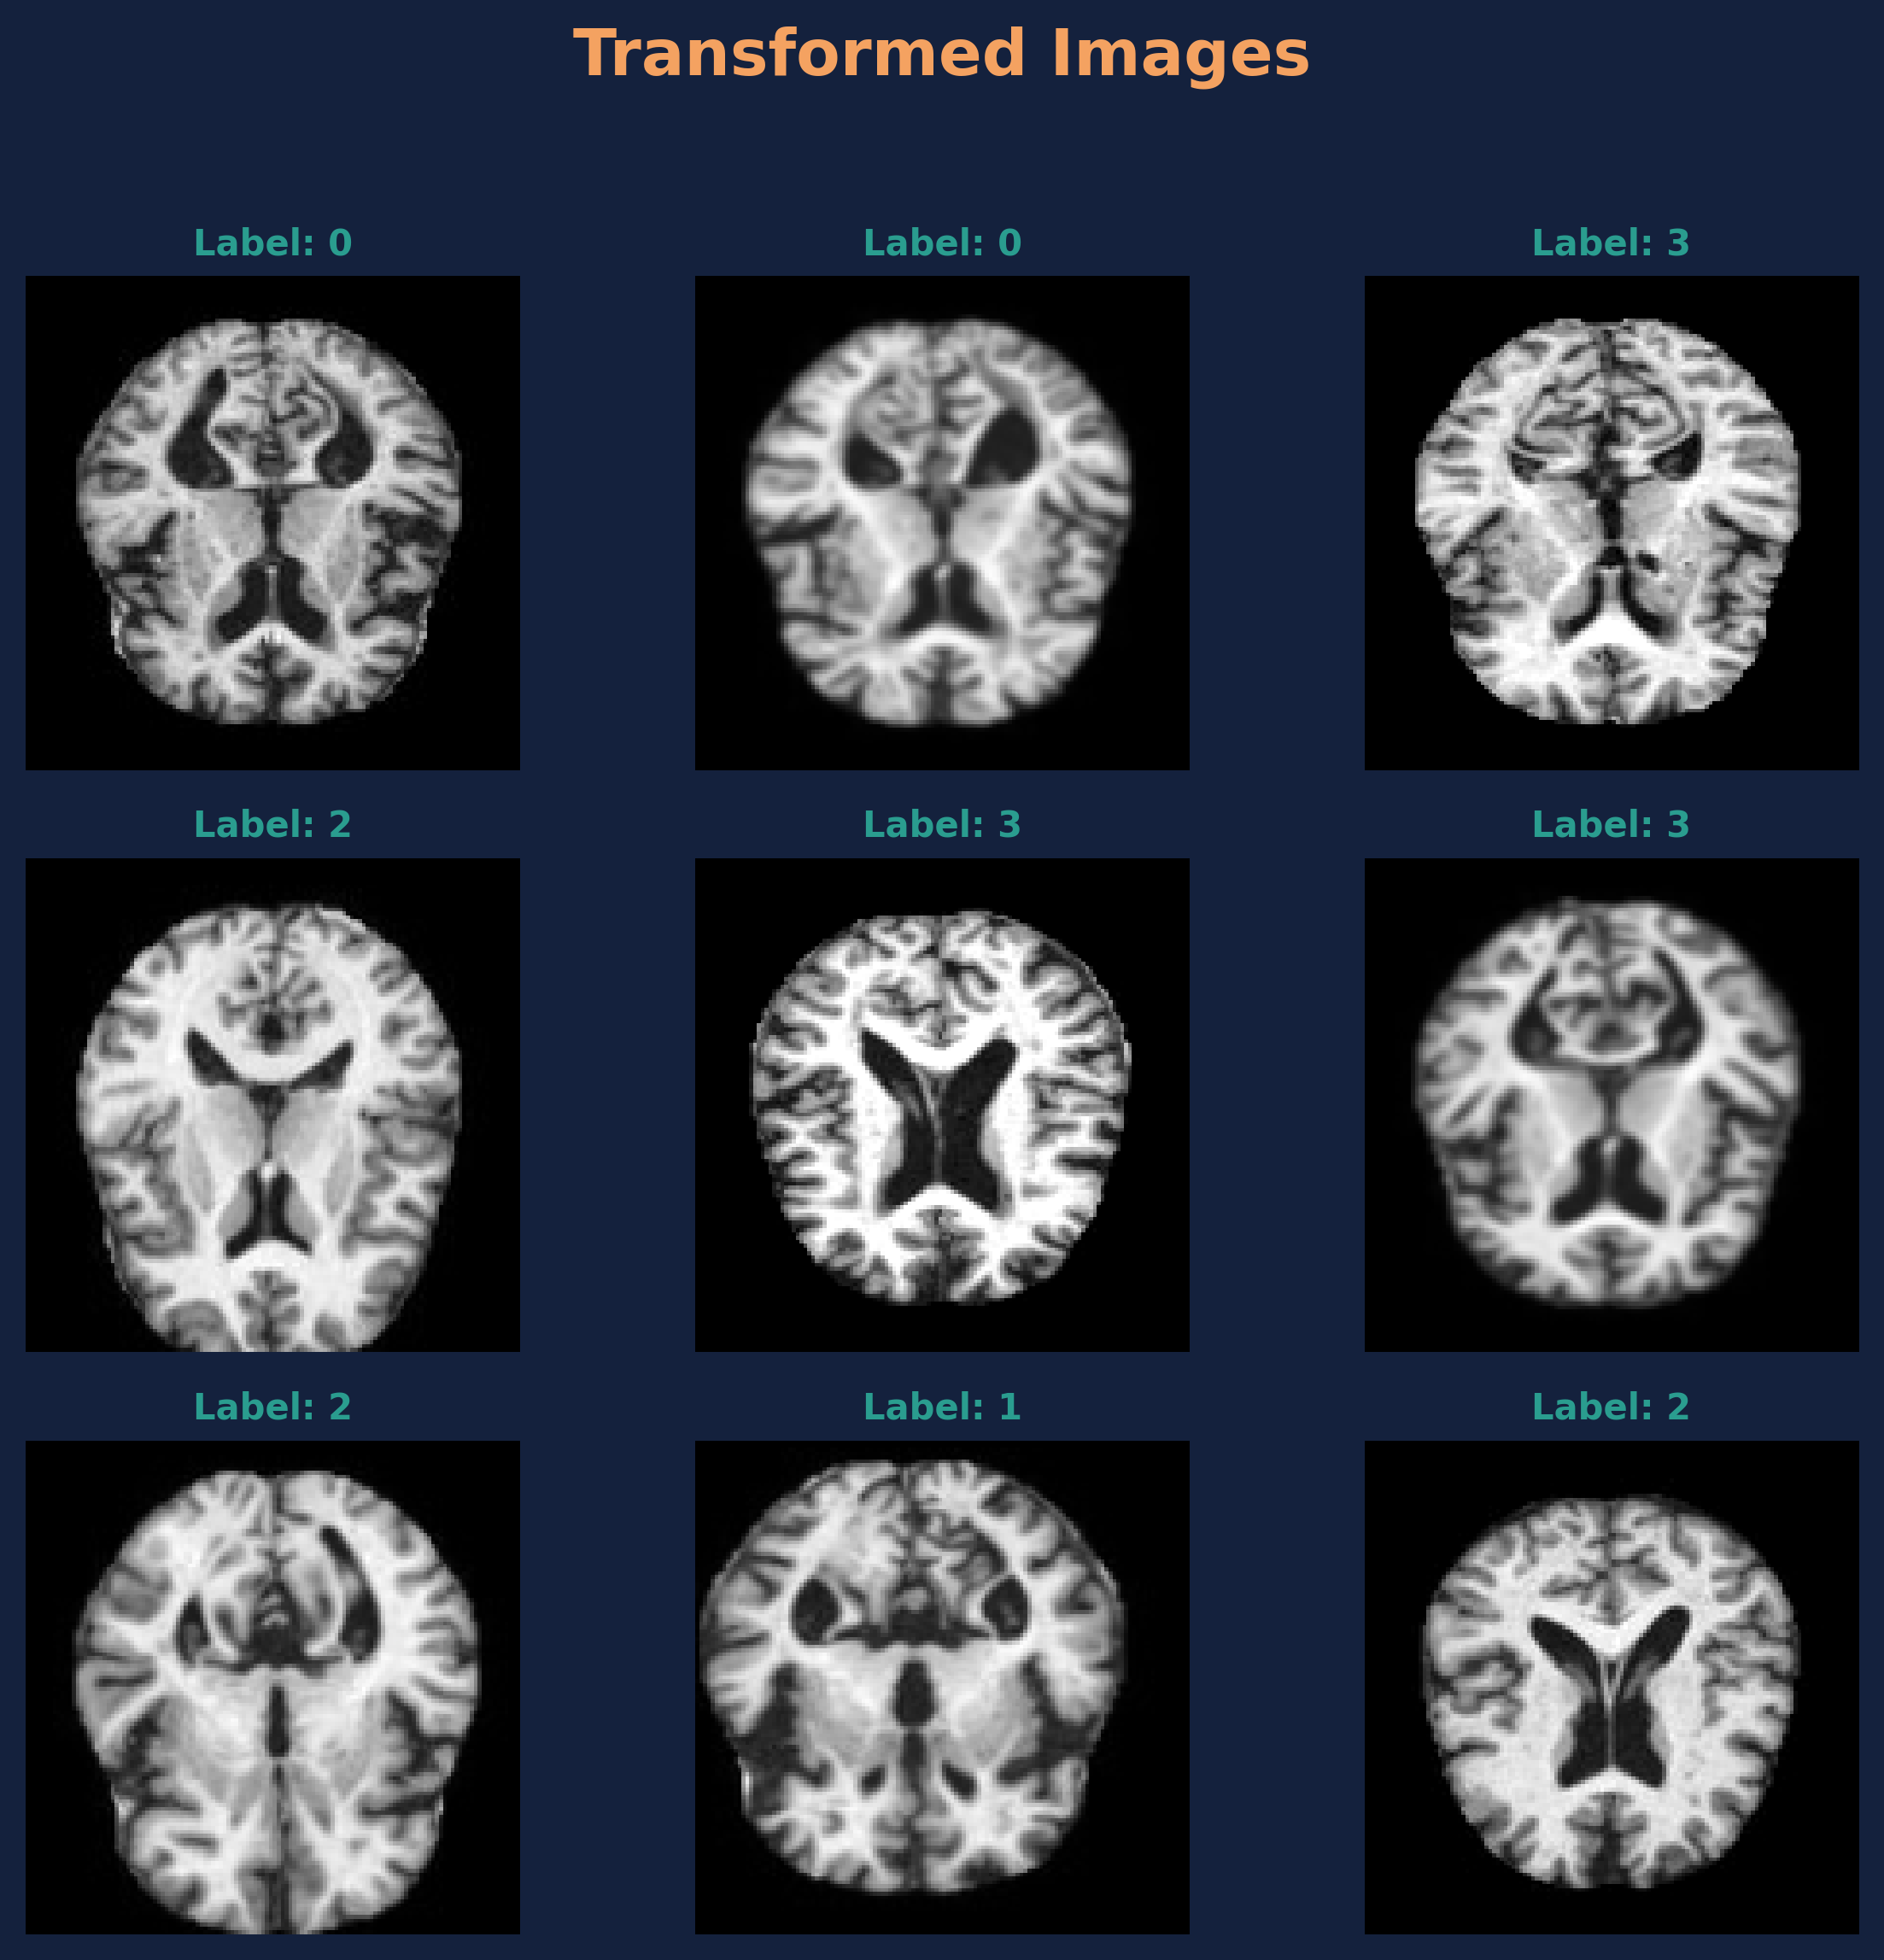

In [20]:
# Visualizza le immagini trasformate con data augmentation
display_transformed_images(train_loader_with_augmentation, 9)

### Model Building 🔨

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

class CustomModel(nn.Module):
    def __init__(self, use_dropout=False, use_max_pooling=True):
        super(CustomModel, self).__init__()
        self.use_dropout = use_dropout
        self.use_max_pooling = use_max_pooling

        # Blocco 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Blocco 2
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Dropout 1
        if self.use_dropout:
            self.dropout1 = nn.Dropout(0.5)

        # Blocco 3
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1 if use_max_pooling else 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) if use_max_pooling else None

        # Blocco 4: è un pooling 1x1 per ridurre numero canali
        self.conv4 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(64)


        # Dropout 2
        if self.use_dropout:
            self.dropout2 = nn.Dropout(0.5)

        # Blocco 5
        self.conv5 = nn.Conv2d(64, 256, kernel_size=3, stride=1 if use_max_pooling else 2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2) if use_max_pooling else None

        # Blocco 6
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1 if use_max_pooling else 2, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.max_pool6 = nn.MaxPool2d(kernel_size=2, stride=2) if use_max_pooling else None

        # Dropout3
        if self.use_dropout:
            self.dropout3 = nn.Dropout(0.5)

        # Blocco 7
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1 if use_max_pooling else 2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.max_pool7 = nn.MaxPool2d(kernel_size=2, stride=2) if use_max_pooling else None

        # Classificazione
        self.fc = nn.Linear(8 * 8 * 256, 4)  # Aggiusta la dimensione in base alla dimensione dell'output del layer precedente

    def forward(self, x):
        def print_size(name, tensor):
            print(f"{name} dimensione dell'output: {tensor.size()}")

        # Blocco 1
        x = F.relu(self.bn1(self.conv1(x)))
        #print_size("Blocco 1", x)

        # Blocco 2
        x = F.relu(self.bn2(self.conv2(x)))
        #print_size("Blocco 2", x)

        # Blocco 3
        x = F.relu(self.bn3(self.conv3(x)))
        if self.use_max_pooling and self.max_pool3:
            x = self.max_pool3(x)
        #print_size("Blocco 3", x)

        # Blocco 4
        x = F.relu(self.bn4(self.conv4(x)))
        #print_size("Blocco 4", x)

        # Blocco 5
        x = F.relu(self.bn5(self.conv5(x)))
        if self.use_max_pooling and self.max_pool5:
            x = self.max_pool5(x)
        #print_size("Blocco 5", x)

        # Blocco 6
        x = F.relu(self.bn6(self.conv6(x)))
        if self.use_max_pooling and self.max_pool6:
            x = self.max_pool6(x)
        #print_size("Blocco 6", x)

        # Blocco 7
        x = F.relu(self.bn7(self.conv7(x)))
        if self.use_max_pooling and self.max_pool7:
            x = self.max_pool7(x)
        #print_size("Blocco 7", x)

        # Appiattimento
        x = x.view(x.size(0), -1)

        # Classificazione
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Creazione del modello: selezionare qui se si desidera usare Dropout e se si desidera usare MaxPooling al posto di stride
model = CustomModel(use_dropout=False, use_max_pooling=False)

# Set device: CONTROLLA SE METTERLO
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definizione dell'ottimizzatore e della funzione di perdita
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Definizione dello scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Stampa del sommario del modello (opzionale)
print(model)

# Crea un input di esempio
example_input = torch.randn(1, 3, 128, 128).to(device)

# Esegui il forward pass con il modello per vedere le dimensioni
model(example_input)


CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

tensor([[-1.9198, -1.3539, -1.7540, -0.8626]], grad_fn=<LogSoftmaxBackward0>)

### Callbacks

In [22]:
class CheckpointCallback:
    def __init__(self, checkpoint_dir='/tmp/checkpoint', monitor='val_accuracy', verbose=1):
        self.checkpoint_dir = checkpoint_dir
        self.monitor = monitor
        self.verbose = verbose
        self.best_accuracy = 0.0

        # Create the directory if it does not exist
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def save_checkpoint(self, model, current_accuracy):
        if current_accuracy > self.best_accuracy:
            if self.verbose:
                print(f'Saving model with {self.monitor}: {current_accuracy:.4f}')
            self.best_accuracy = current_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

class EarlyStopping:
    def __init__(self, patience=5, monitor='val_accuracy', verbose=1):
        self.patience = patience
        self.monitor = monitor
        self.verbose = verbose
        self.counter = 0
        self.best_accuracy = 0.0
        self.early_stop = False

    def check_early_stopping(self, current_accuracy):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'{self.monitor} not improved for {self.counter} consecutive epochs.')
            if self.counter >= self.patience:
                print('Early stopping activated.')
                self.early_stop = True

# Callback usage
checkpoint_callback = CheckpointCallback()
early_stopping = EarlyStopping(patience=5, monitor='val_accuracy')
EPOCHS = 20  # Number of epochs for training

### Training

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'\n Start of epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        # Checkpoint and early stopping
        checkpoint_callback.save_checkpoint(model, val_acc)
        early_stopping.check_early_stopping(val_acc)

        if early_stopping.early_stop:
            print('Early stopping activated.')
            break
        else:
            print(f'Validation not improved for {early_stopping.counter} consecutive epochs.')

        if scheduler is not None:
            scheduler.step(val_loss)

    print('Training complete')
    return model, train_losses, val_losses, train_accuracies, val_accuracies, early_stopping

# Ensure the model, loaders, criterion, and optimizer are defined
model, train_losses, val_losses, train_accuracies, val_accuracies, early_stopping = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20
)



 Start of epoch 1/20


KeyboardInterrupt: 

### Loss and Accuracy

In [ ]:
# Plot delle curve di loss e accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5), facecolor="#70c1b3")

# Plot della Loss
ax[0].set_facecolor('#c9e4de')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=12)
ax[0].plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="#073b4c")
ax[0].plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="#ef476f", linestyle="dashed")
ax[0].legend()

# Plot dell'Accuracy
ax[1].set_facecolor('#c9e4de')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=12)
ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc.", color="#073b4c")
ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

plt.show()

### Evaluating Test Data

In [ ]:
# Evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Acc: {test_acc:.4f}')

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Lista per raccogliere predizioni e labels
predictions = []
true_labels = []

# Imposta il modello in modalità di valutazione
model.eval()

# Disabilita il calcolo del gradiente per la valutazione
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ottieni le predizioni dal modello
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Estendi le liste con predizioni e labels reali
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Converti le liste in array numpy
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Stampa il rapporto di classificazione
print(classification_report(true_labels, predictions, target_names=class_names))


### Confusion Matrix

In [ ]:
# Utilizza il modello addestrato per fare le predizioni sui dati di validazione
model.eval()  # Imposta il modello in modalità valutazione
predictions = []
true_labels = []
for inputs, labels in val_loader:
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calcola la matrice di confusione
cm = confusion_matrix(true_labels, predictions)

# Crea un DataFrame per la matrice di confusione
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Visualizza la matrice di confusione
plt.figure(figsize=(6,4), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="magma", fmt=".1f", annot_kws={"size": 8})
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")
plt.show()

Let's create a function that fetches a random image and displays a pie chart showing the probability distribution of which target value the image belongs to, represented as percentages. In this way, it will be seen which class the model gives the highest probability to.

### Alzheimer Probability of a Random MRI from Test Data

In [ ]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def random_mri_prob_bringer(image_number=0):
    model.eval()  # Imposta il modello in modalità di valutazione

    with torch.no_grad():  # Disattiva il calcolo del gradiente
        for images, labels in test_loader:
            image = images[image_number]
            true_label = labels[image_number].item()  # Ottiene l'etichetta vera
            output = model(image.unsqueeze(0).to(device))  # Aggiunge una dimensione batch e sposta su GPU
            pred = output.cpu().numpy()[0]
            break  # Aggiunge un break per uscire dal ciclo dopo aver ottenuto l'immagine e l'etichetta

    probs = F.softmax(torch.tensor(pred), dim=0).numpy()
    probs_dict = dict(zip(class_distribution.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='#14213d')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image.permute(1, 2, 0).cpu().numpy())
    true_label_str = list(class_distribution.keys())[true_label]  # Converte l'etichetta in stringa utilizzando class_distribution
    ax1.set_title(f'Brain MRI\nTrue Label: {true_label_str}', color="#fca311", fontweight="bold", fontsize=16)


    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "#fca311"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys, autopct='%1.1f%%',
                                      shadow=True, startangle=90, colors=colors,
                                      textprops={'fontsize': 8, "fontweight":"bold", "color":"#fca311"},
                                      wedgeprops={'edgecolor':'black'}, labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="#fca311", fontweight="bold", fontsize=16)

    plt.show()

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)







Now, let's see the actual classes and predicted classes of these samples by bringing samples from our test data.

### Comparing Predicted Classes with the Actual Classes from the Test Data

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, class_names, num_images=25):
    num_rows = (num_images - 1) // 5 + 1  # Calcola il numero di righe necessarie
    plt.figure(figsize=(20, 4 * num_rows), facecolor="#14213d")
    model.eval()  # Imposta il modello in modalità di valutazione

    with torch.no_grad():  # Disattiva il calcolo del gradiente
        for i, (images, labels) in enumerate(test_loader):
            if i * len(images) >= num_images:
                break

            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            probabilities = torch.softmax(outputs, dim=1)

            for j in range(len(images)):
                if i * len(images) + j >= num_images:
                    break

                ax = plt.subplot(num_rows, 5, i * len(images) + j + 1)
                plt.imshow(images[j].permute(1, 2, 0).cpu().numpy())

                actual_class = class_names[labels[j]]
                predicted_class = class_names[preds[j]]
                confidence = probabilities[j][preds[j]].item()

                if actual_class == predicted_class:
                    plt.title(f"Actual: {actual_class}", color="#fca311", fontweight="bold", fontsize=10)
                    plt.ylabel(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})", color="springgreen", fontweight="bold", fontsize=10)
                    ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
                    ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
                else:
                    plt.title(f"Actual: {actual_class}", color="#fca311", fontweight="bold", fontsize=10)
                    plt.ylabel(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})", color="maroon", fontweight="bold", fontsize=10)
                    nok_text = plt.text(2, 10, "NOT OK \u2718", color="red", fontsize=14)
                    nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

                ax.axes.yaxis.set_ticklabels([])
                ax.axes.xaxis.set_ticklabels([])

    plt.tight_layout()
    plt.show()

# Utilizza il modello addestrato per fare le predizioni sui dati di test
visualize_predictions(model, test_loader, class_names)
